In [2]:
import drawSvg as draw
from drawSvg.widgets import DrawingWidget
import hyperbolic.poincare.shapes as hyper  # pip3 install hyperbolicd
import numpy as np

canvas_size=(800,800)
# Create drawing
d = draw.Drawing(*canvas_size, origin='center')

linkage = draw.Group()
d.append(linkage)
traj=draw.Group()
d.append(traj)


def redraw_linkage(nodes=[], edges=[],node_radius=6,edge_width=5):
    linkage.children.clear()
    for id1,id2 in edges:
        linkage.draw(draw.Line(*nodes[id1],*nodes[id2],stroke='gray',stroke_width=edge_width))
    for x,y in nodes[1:-1]:
        linkage.draw(draw.Circle(x,y,node_radius,fill='green'))
    x,y=nodes[0]
    linkage.draw(draw.Circle(x,y,node_radius,fill='blue'))
    x,y=nodes[-1]
    linkage.draw(draw.Circle(x,y,node_radius,fill='orange'))

def redraw_trajectory(drive_node=[],end_node=[]):
    traj.children.clear()
    for p0,p1 in zip(drive_node[:-1],drive_node[1:]):
        traj.draw(draw.Line(*p0,*p1,stroke='blue',stroke_width=3))
    for p0,p1 in zip(end_node[:-1],end_node[1:]):
        traj.draw(draw.Line(*p0,*p1,stroke='orange',stroke_width=3))
        
        
def rotation_matrix(theta=0):
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def simulate_linkage(nodes=[],edges=[],lengths=[]):
    for i in range(0,len(edges),2):
        e02,e12=edges[[i,i+1],:]
        l02,l12=lengths[[i,i+1]]
        p0,p1=nodes[[e02[0],e12[0]],:]
        if np.linalg.norm(p1-p0)>l02+l12:
            p0=p1-(l02+l12)*(p1-p0)/np.linalg.norm(p1-p0)
            nodes[e02[0],:]=p0
        v01=(p1-p0)/np.linalg.norm(p1-p0)
        l01=np.linalg.norm(p1-p0)
        phi=np.arccos(max(-1,min(1,(l01**2+l02**2-l12**2)/(2*l01*l02))))
        p2=rotation_matrix(phi)@v01*l02+p0
        nodes[e02[1],:]=p2

<IPython.core.display.Javascript object>

In [3]:
nodes=np.array([(100,100),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)])
edges=np.array([(0,2),(1,2),(2,3),(1,3),(1,4),(0,4),(3,5),(4,5),(5,6),(4,6)])
lengths=np.array([100,100,100,100,100,150,100,100,150,100])
drive_node=[]
end_node=[]
# Create interactive widget and register mouse events
widget = DrawingWidget(d)
@widget.mousedown
def mousedown(widget, x, y, info):
    drive_node.append([*nodes[0]])
    if len(drive_node)>1:
        for i in range(0,10):
            nodes[0,:]=(1-i/10.0)*np.asarray(drive_node[-2])+(i/10.0)*np.asarray(drive_node[-1])
            simulate_linkage(nodes,edges,lengths)
            end_node.append([*nodes[-1]])
        nodes[0,:]=drive_node[-1]
    else:
        end_node.append([*nodes[-1]])
    redraw_trajectory(drive_node,end_node)
    redraw_linkage(nodes,edges)
    widget.refresh()
@widget.mousemove
def mousemove(widget, x, y, info):
    nodes[0]=(x,y)
    simulate_linkage(nodes,edges,lengths)
    redraw_trajectory(drive_node,end_node)
    redraw_linkage(nodes,edges)
    widget.refresh()
widget

DrawingWidget()

In [23]:
result

array([], dtype=float64)

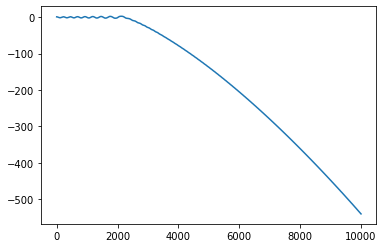

In [44]:
# dynamics simulation 

def get_force(angle, mass): return mass * -9.81 * np.sin(angle)
# game loop implementation

# system parameters
pendulum_mass = 0.7  #kg
pendulum_string_length = 0.1 #m

# step
dt = 0.01

# system state (incl. initial conditions)
pendulum_angle = 1.2
pendulum_angular_velocity = 0

result = []

# step between 0s and 10s every dt seconds
for step in np.arange(0.0, 100.0, dt):
    # get acceleration
    # F = m*a  ->  a = F/m
    acceleration = get_force(pendulum_angle, pendulum_mass) / pendulum_mass
    
    # do the time step
    pendulum_angle += pendulum_angular_velocity * dt
    pendulum_angular_velocity += acceleration * dt
    result.append(pendulum_angle)
    
plt.plot(result)
plt.show()

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 11804
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.08616336e-02, 7.46234712e-02, ...,
       9.99246929e+01, 9.99876003e+01, 1.00000000e+02])
 t_events: None
        y: array([[ 0.00000000e+00, -1.14092332e-01, -7.83856846e-01, ...,
        -1.04962492e+03, -1.05028570e+03, -1.05041595e+03],
       [ 1.00000000e+01,  1.00060718e+01,  1.02725204e+01, ...,
         1.00512955e+01,  1.04244246e+01,  1.05303975e+01]])
 y_events: None

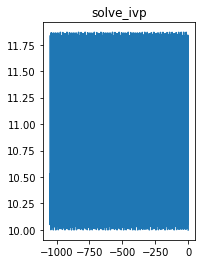

In [46]:
import matplotlib.pyplot as plt

# is an approximation since time is discretized

# let's be a little smarter about discretization

# battle plan formulate system as a continuous-time model -> pass it to a differential equation solver

# function that returns dy/dt
# variable naming convention from control theory:
# y -> system state vector (sometimes 'u')
# t -> time
# p -> parameter vector
def model(t, y, p=()):
    pendulum_angle = y[0]
    pendulum_anglular_velocity = y[1]
    
    acceleration = get_force(pendulum_angle, pendulum_mass) / pendulum_mass
    
    return [pendulum_angular_velocity, acceleration]

# initial condition
y0 = [0,10]

from scipy.integrate import solve_ivp


# time points
time_span = (0.0, 100.0)

# solve ODEs
k = 0.1
result = solve_ivp(model, time_span, y0, method='RK45', rtol=1e-8)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 2)
ax.plot(result.y[0, :],
        result.y[1, :])
ax.set_title("solve_ivp")
result
# time plot

In [48]:
# TODO state-space-plot

In [51]:
# TODO make this work for the linkage system


In [ ]:
# TODO run FFT on the data